replicate the steps from Brats: https://cbica.github.io/CaPTk/preprocessing_brats.html

1. unify orientations using MONAI
2. Register all modalites to T1w
3. Register T1w to template (https://www.nitrc.org/projects/sri24)
4. Perform skull stripping on T1w

# 1. BraTS 2021 Reference Visualization

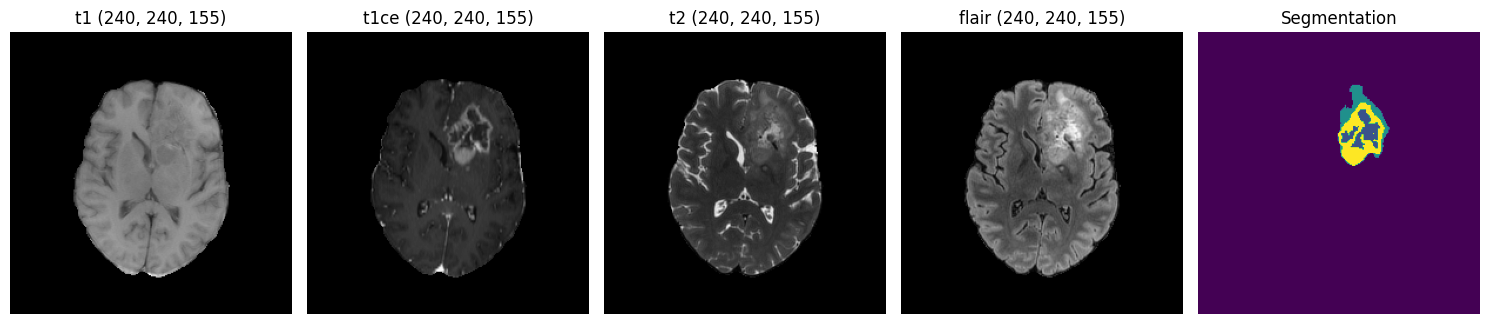

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

brats_modalities = ["t1", "t1ce", "t2", "flair"]
shape = nib.load('data/brats_2021/TrainingData/BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata().shape
imgs = [nib.load(f"data/brats_2021/TrainingData/BraTS2021_00000/BraTS2021_00000_{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 77] for m in brats_modalities]
lbl = nib.load("data/brats_2021/TrainingData/BraTS2021_00000/BraTS2021_00000_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 77]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img.T, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f"{brats_modalities[i]} {shape}")  # Set title for each modality image

ax[-1].imshow(lbl.T, vmin=0, vmax=4)
ax[-1].axis('off')
ax[-1].set_title("Segmentation")  # Set title for the label image

plt.tight_layout()            
plt.show()


# 2. OASIS-3 Raw MRI

sub-OAS30001_ses-d0129_run-02_T1w.nii.gz
sub-OAS30001_ses-d0129_acq-TSE_T2w.nii.gz
sub-OAS30001_ses-d0129_run-01_T1w.nii.gz
sub-OAS30001_ses-d0129_T2w.nii.gz


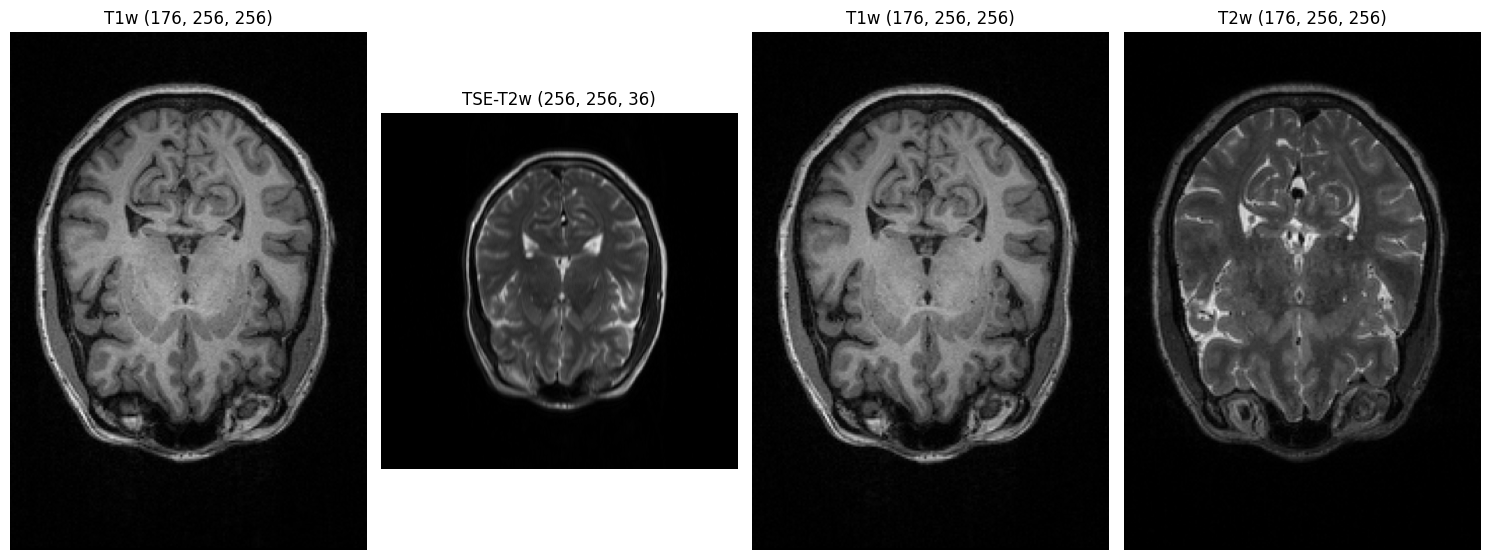

In [202]:
from oasis_util import visualize_structural_mri_session

visualize_structural_mri_session(session_directory="./data/oasis-3/OAS30001_MR_d0129/")

sub-OAS30852_ses-d2307_run-01_T1w.nii.gz
sub-OAS30852_ses-d2307_run-04_T1w.nii.gz
sub-OAS30852_ses-d2307_acq-TSE_run-01_T2w.nii.gz
sub-OAS30852_ses-d2307_acq-TSE_run-02_T2w.nii.gz
sub-OAS30852_ses-d2307_run-03_T1w.nii.gz
sub-OAS30852_ses-d2307_run-02_T1w.nii.gz


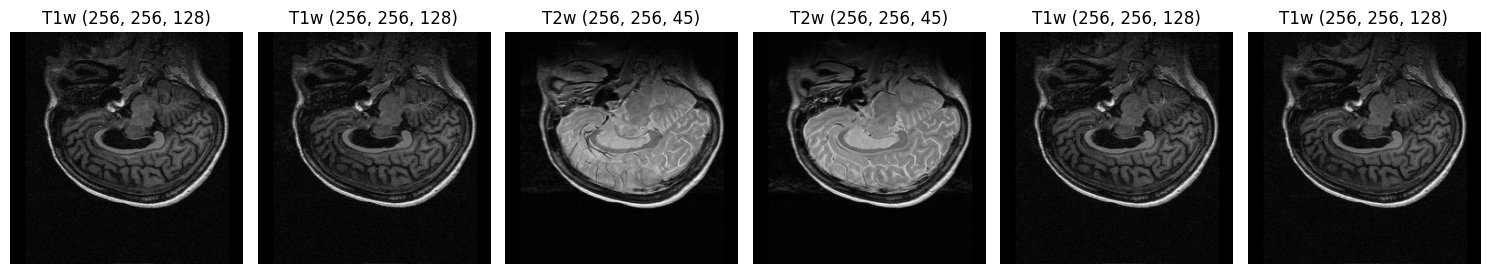

In [201]:
visualize_structural_mri_session(session_directory="./data/oasis-3/OAS30852_MR_d2307/")

# 3. Reorientation & Bounding Box Registration with MONAI

In [261]:
import os
from monai.transforms import LoadImaged, Orientationd, Compose, EnsureChannelFirstd, Lambdad, Transform, CropForegroundd, ScaleIntensityd, Resized, SpatialPadd
import nibabel as nib
import glob


class CustomOrientation(Transform):
    def __init__(self, keys, axcodes, fallback_axcodes):
        self.keys = keys
        self.axcodes = axcodes
        self.fallback_axcodes = fallback_axcodes
        self.orientation = Orientationd(keys, axcodes=axcodes)
        self.orientation_fallback = Orientationd(keys, axcodes=fallback_axcodes)

    def __call__(self, data):
        d = dict(data)
        # Check metadata
        if d["img_meta_dict"]["qform_code"] == 0 and d["img_meta_dict"]["sform_code"] == 0:
            print(f"Image at {d['img_meta_dict']['filename_or_obj']} does not have valid orientation metadata. Setting orientation to {self.fallback_axcodes}.")
            return self.orientation_fallback(d)
        else:
            return self.orientation(d)

def check_affine(data):    
    if data["qform_code"] == 0 and data["sform_code"] == 0:
        data["affine"] = np.eye(1)
    return data

resolution = 240
# Define the transform pipeline
transforms = Compose([
    LoadImaged("img", image_only=False),  # Only loads the image and not the metadata
    #Spacingd(keys=["img"], pixdim=(1.0, 0.5, 1.0), mode='bilinear'),
    Lambdad("img_meta_dict", check_affine),
    EnsureChannelFirstd("img"),
    ScaleIntensityd("img"),
    #Orientationd("img", axcodes="LPS")
    CustomOrientation("img", axcodes='LPS', fallback_axcodes="SRA"),  # Transform to RAS orientation or any desired orientation
    CropForegroundd("img", source_key="img", select_fn=lambda x: x > 0.5, margin=50),
    Resized(keys=["img"], spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=["img"], spatial_size=(resolution, resolution, 155)),
])

# Path to the directory containing nii.gz images
data_dir = "./data/oasis-3/"
image_paths = [{"img": path} for path in glob.glob(os.path.join(data_dir, '**', '*.nii.gz'), recursive=True)]

for image_path in image_paths:
    try:
        processed_image = transforms(image_path)
        
        # Construct the output path by replacing 'oasis-3' with 'oasis-3-proc-1'
        relative_path = os.path.relpath(image_path["img"], data_dir)
        output_path = os.path.join("./data/oasis-3-proc-1/", relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        nib.save(nib.Nifti1Image(processed_image["img"][0], affine=None), output_path)
    
    except ValueError as e:
        print(e)

Image at data/oasis-3/OAS30852_MR_d2307/anat3/sub-OAS30852_ses-d2307_run-01_T1w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.
Image at data/oasis-3/OAS30852_MR_d2307/anat6/sub-OAS30852_ses-d2307_run-04_T1w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.
Image at data/oasis-3/OAS30852_MR_d2307/anat1/sub-OAS30852_ses-d2307_acq-TSE_run-01_T2w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.
Image at data/oasis-3/OAS30852_MR_d2307/anat2/sub-OAS30852_ses-d2307_acq-TSE_run-02_T2w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.
Image at data/oasis-3/OAS30852_MR_d2307/anat5/sub-OAS30852_ses-d2307_run-03_T1w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.
Image at data/oasis-3/OAS30852_MR_d2307/anat4/sub-OAS30852_ses-d2307_run-02_T1w.nii.gz does not have valid orientation metadata. Setting orientation to SRA.


BraTS2021_00000_t1.nii.gz
BraTS2021_00000_flair.nii.gz
BraTS2021_00000_t2.nii.gz
BraTS2021_00000_seg.nii.gz
BraTS2021_00000_t1ce.nii.gz


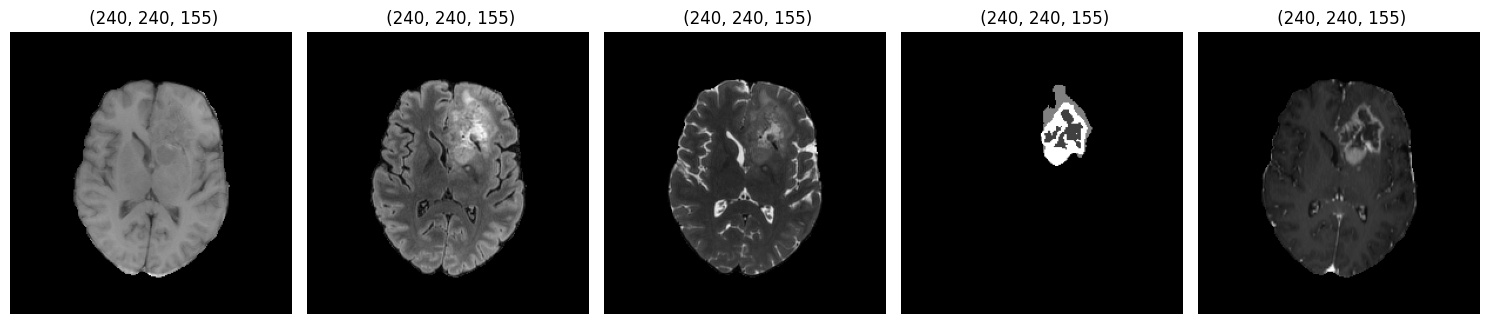

In [235]:
visualize_structural_mri_session(session_directory="./data/brats_2021/TrainingData/BraTS2021_00000/")

sub-OAS30001_ses-d0129_run-02_T1w.nii.gz
sub-OAS30001_ses-d0129_acq-TSE_T2w.nii.gz
sub-OAS30001_ses-d0129_run-01_T1w.nii.gz
sub-OAS30001_ses-d0129_T2w.nii.gz


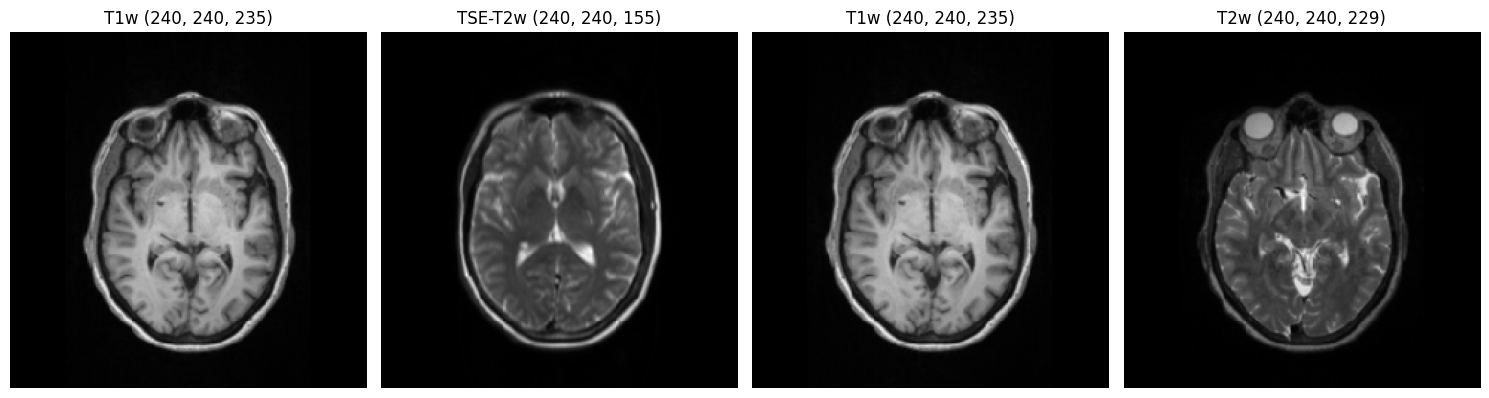

In [262]:
visualize_structural_mri_session(session_directory="./data/oasis-3-proc-1/OAS30001_MR_d0129/")

sub-OAS30852_ses-d2307_run-01_T1w.nii.gz
sub-OAS30852_ses-d2307_run-04_T1w.nii.gz
sub-OAS30852_ses-d2307_acq-TSE_run-01_T2w.nii.gz
sub-OAS30852_ses-d2307_acq-TSE_run-02_T2w.nii.gz
sub-OAS30852_ses-d2307_run-03_T1w.nii.gz
sub-OAS30852_ses-d2307_run-02_T1w.nii.gz


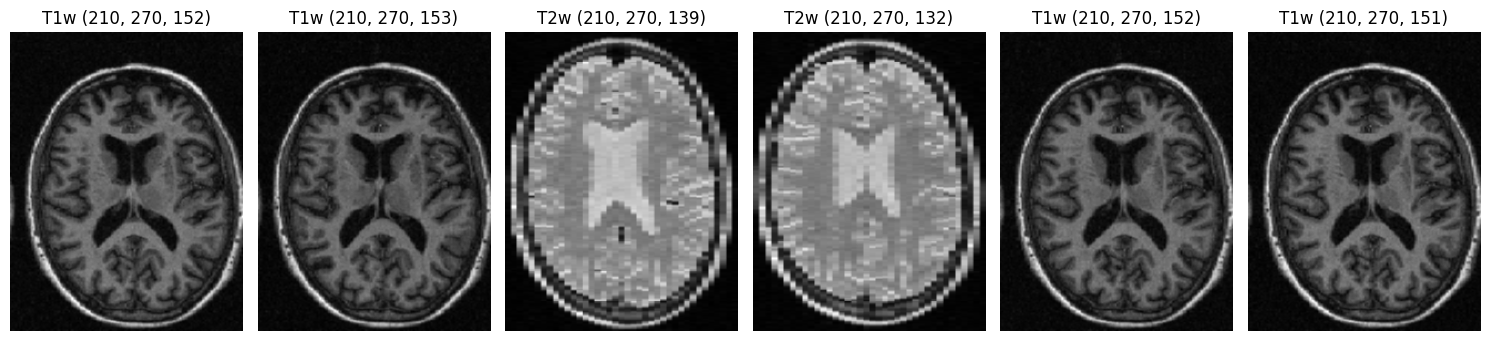

In [260]:
visualize_structural_mri_session(session_directory="./data/oasis-3-proc-1/OAS30852_MR_d2307/")